# Solving Newton’s Law of Cooling Using Physics-Informed Neural Networks (PINNs)

## Problem Statement

Newton’s Law of Cooling describes how the temperature $T(t)$ of a hot object evolves as it approaches the ambient temperature $T_{\rm ambient}$. In differential form:

$$
\frac{dT}{dt}\;-\;k\bigl(T_{\rm ambient}-T(t)\bigr)\;=\;0,\qquad t\ge0
$$

Where:  
- $T(t)$ is the object’s temperature at time $t$.  
- $T_{\rm ambient}$ is the surrounding (ambient) temperature.  
- $k$ is the cooling rate constant (s⁻¹).  
- We enforce the **initial condition**  
  $$
  T(0) = T_{0}.
  $$

For our example we set:  
- $T_{\rm ambient} = 27^\circ\mathrm{C}$  
- $T_{0} = 250^\circ\mathrm{C}$  
- $k = 0.45\;\mathrm{s}^{-1}$

---

## Analytical Solution

The exact solution of
$$
\frac{dT}{dt} = k\,(T_{\rm ambient} - T)
$$
with $T(0)=T_{0}$ is

$$
\boxed{
T_{\rm exact}(t)
=
T_{\rm ambient}
+
\bigl(T_{0} - T_{\rm ambient}\bigr)\,e^{-k\,t}
}.
$$

This provides a reference curve against which to validate our PINN.

---

## PINN Objective

We approximate $T(t)$ by a neural network $\hat T(t;\theta)$. Training minimizes the combined loss

$$
\mathcal{L}
=
\underbrace{\mathrm{MSE}_{\rm res}}_{\text{ODE residual}}
+
\underbrace{\mathrm{MSE}_{\rm ic}}_{\text{initial condition}}
$$

where

- **Residual loss**  
  $$
  \mathrm{MSE}_{\rm res}
  =
  \frac{1}{N_r}
  \sum_{i=1}^{N_r}
    \Bigl(
      \frac{d}{dt}\hat T(t_i)
      -
      k\bigl(T_{\rm ambient}-\hat T(t_i)\bigr)
    \Bigr)^{2},
  $$
  evaluated at $t_i$ sampled in the interior.

- **Initial condition loss**  
  $$
  \mathrm{MSE}_{\rm ic}
  =
  \bigl(\hat T(0)-T_{0}\bigr)^{2}.
  $$

---

## Why Use PINNs?

- **Mesh-free & flexible**: sample residual points anywhere in time.  
- **Physics-aware loss**: the ODE is enforced directly.  
- **Automatic differentiation**: easily compute $d\hat T/dt$.  
- **Continuous surrogate**: once trained, $\hat T(t)$ is valid for all $t\ge0$ without interpolation.

Let’s now implement and train our PINN to recover the cooling curve!  


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [129]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.net(x)

In [130]:
def ode(network, t, k, T_ambient):
    t = t.clone().detach().requires_grad_(True)

    T = network(t)   # Network Prediction
    T_t = torch.autograd.grad(T, t, grad_outputs=torch.ones_like(T), create_graph=True)[0]   # First Derivative

    return T_t - (k * (T_ambient - T))

In [131]:
def loss(network, t, T_ambient, t0, T0, k):
    # ODE residual loss
    res = ode(network, t, k, T_ambient)
    MSE_res = torch.mean(res**2)

    # initial-condition loss
    T0_pred = network(t0)
    MSE_ic = torch.mean((T0_pred  - T0)**2)

    return 2*MSE_res + MSE_ic

In [132]:
def train(network, t, T_ambient, t0, T0, k, epochs, lr = 1e-3):
    optimizer = torch.optim.Adam(network.parameters(), lr=lr)
    loss_list = []

    for epoch in range(1, epochs + 1):
        optimizer.zero_grad()
        loss_value = loss(network, t, T_ambient, t0, T0, k)
        loss_list.append(loss_value.item())
        loss_value.backward()
        optimizer.step()

        if epoch % 100 == 0 or epoch == 1:
            print(f"Epoch {epoch}/{epochs} — Loss: {loss_value.item():.3e}")

    return loss_list

In [133]:
# Collocation points in the interior
t_train = np.linspace(0, 12, 1000).reshape(-1,1)
t_train = torch.tensor(t_train, dtype=torch.float32)

# 
T_ambient = 27
k = 0.45
t0 = torch.tensor([[0.0]],   dtype=torch.float32)
T0 = torch.tensor([[250.0]], dtype=torch.float32)

# Training hyperparameters
epochs = 2500
lr = 1e-2

#  Instantiate and train the model
model = NeuralNetwork()
loss_list = train(model, t_train, T_ambient, t0, T0, k, epochs, lr)


Epoch 1/2500 — Loss: 6.279e+04
Epoch 100/2500 — Loss: 3.941e+04
Epoch 200/2500 — Loss: 2.636e+04
Epoch 300/2500 — Loss: 1.946e+04
Epoch 400/2500 — Loss: 1.624e+04
Epoch 500/2500 — Loss: 1.495e+04
Epoch 600/2500 — Loss: 3.689e+03
Epoch 700/2500 — Loss: 1.437e+03
Epoch 800/2500 — Loss: 5.116e+02
Epoch 900/2500 — Loss: 1.681e+02
Epoch 1000/2500 — Loss: 5.310e+01
Epoch 1100/2500 — Loss: 1.714e+01
Epoch 1200/2500 — Loss: 6.305e+00
Epoch 1300/2500 — Loss: 2.940e+00
Epoch 1400/2500 — Loss: 1.729e+00
Epoch 1500/2500 — Loss: 1.166e+00
Epoch 1600/2500 — Loss: 8.311e-01
Epoch 1700/2500 — Loss: 6.040e-01
Epoch 1800/2500 — Loss: 4.413e-01
Epoch 1900/2500 — Loss: 3.228e-01
Epoch 2000/2500 — Loss: 2.425e-01
Epoch 2100/2500 — Loss: 1.746e-01
Epoch 2200/2500 — Loss: 1.283e-01
Epoch 2300/2500 — Loss: 9.692e-02
Epoch 2400/2500 — Loss: 5.373e-01
Epoch 2500/2500 — Loss: 8.963e-02


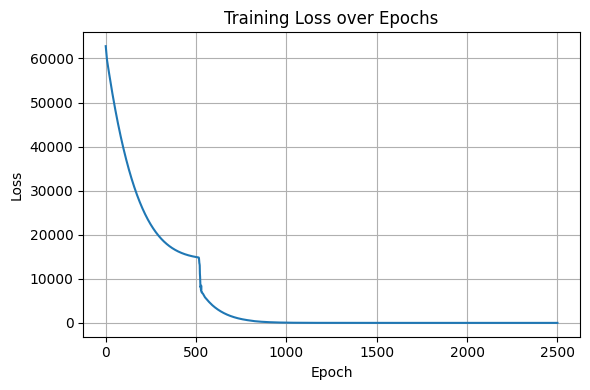

In [134]:
plt.figure(figsize=(6,4))
plt.plot(range(1, epochs+1), loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.tight_layout()
plt.show()

### Testing the model

In [135]:
def analytical(t, T_ambient, T0, k):
    return T_ambient + ((T0 - T_ambient) * np.exp(-k*t))

In [136]:
t_test = torch.linspace(0, 12, 200).unsqueeze(1)
t_test = torch.tensor(t_test, dtype=torch.float32)

model.eval()

with torch.no_grad():
    y_pred = model(t_test)

y_pred_np = y_pred.cpu().numpy()

# Analytical Solution
t_test_np = t_test.cpu().numpy().flatten()
y_true = analytical(t_test_np, T_ambient, T0.item() if torch.is_tensor(T0) else T0, k)

/tmp/ipykernel_2512/2155231056.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_test = torch.tensor(t_test, dtype=torch.float32)


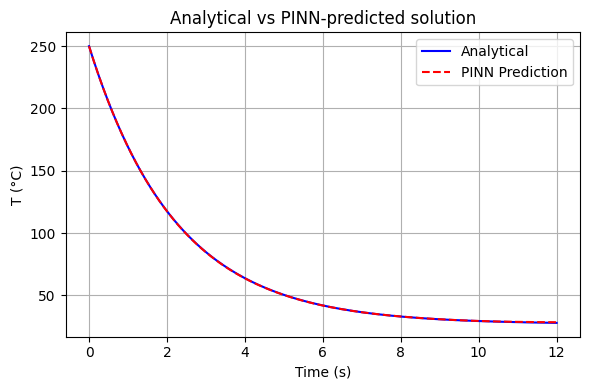

In [137]:
# Plot the Results
plt.figure(figsize=(6,4))

plt.plot(t_test, y_true, 'b-', label='Analytical')
plt.plot(t_test, y_pred_np, 'r--', label='PINN Prediction')
plt.xlabel('Time (s)')
plt.ylabel('T (°C)')
plt.title('Analytical vs PINN‐predicted solution')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()